In [1]:
import math
import numpy as np
import torch
import gpytorch as gp
import botorch as bo
from botorch.models.gpytorch import GPyTorchModel
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
class prior(gp.models.ExactGP, GPyTorchModel):
    _num_outputs = 1
    
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)
        

def camel(x1, x2):
    ans = (4 - 2.1*x1**2 + x1**4/3)*x1**2
    ans += x1*x2
    ans += (-4 + 4*x2**2)*x2**2
    return ans

def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

def a_pi(fmin, mean, std, fmax, e=0.01):
    tau = mean - e*(fmax-fmin)
    ans = norm.cdf((fmin - tau)/std)
    return torch.from_numpy(ans)

def a_ucb(mean, std, beta=2):
    ans = mean - (beta*std)
    return -ans

def gap(best_found, best_init, best):
    ans = (best_found - best_init)/(best - best_init)
    return ans

In [3]:
num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
domain = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
f = torch.log(camel(domain[:, 0], domain[:, 1]) + 1.2)

a_num = 6
num_runs = 20
gaps = torch.zeros((6, num_runs, 30))

for run in range(num_runs):
    D_idx = np.random.choice(num*num, 5, False)
    D_X = domain[D_idx]
    D_y = f[D_idx]

    for idx in D_idx:
        domain = torch.cat((domain[:idx], domain[idx+1:]), dim=0)
        f = torch.cat((f[:idx], f[idx+1:]))

    D_fmin = torch.min(D_y)
    fmin_init = torch.min(D_y)
    best = math.log(-1.0316+1.2)

    for i in range(a_num):
        D_X_cur = D_X.clone()
        D_y_cur = D_y.clone()
        D_fmin_cur = torch.min(D_y_cur)
        D_fmax_cur = torch.max(D_y_cur)
        domain_cur = domain.clone()
        f_cur = f.clone()

        budget = 30
        for t in range(budget):
            # Initialize model
            likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X_cur.shape[0])*(0.01**2))
            k = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
            k.outputscale = 2.2065
            k.base_kernel.lengthscale = 0.9387
            model = prior(D_X_cur, D_y_cur, likelihood, k)
            model.mean_module.constant = torch.nn.parameter.Parameter(torch.tensor(3.4147))

            # Measure Acquisition Function
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gp.settings.fast_pred_var():
                f_preds = likelihood(model(domain_cur), noise=torch.ones(domain_cur.shape[0]) * (0.01**2))
            f_means = f_preds.mean.detach()
            f_stds = torch.sqrt(f_preds.variance).detach()

            if i == 0:
                aqs_cur = a_ei(D_fmin_cur, f_means, f_stds)
            elif i == 1:
                aqs_cur = torch.zeros(num*num)
            elif i == 2:
                aqs_cur = a_ucb(f_means, f_stds, 0.5)
            elif i == 3:
                aqs_cur = a_ucb(f_means, f_stds, 1)
            elif i == 4:
                aqs_cur = a_ucb(f_means, f_stds, 2)
            else:
                aqs_cur = a_ucb(f_means, f_stds, 3)

            # Observe
            if i == 1:
                max_idx = np.random.choice(domain_cur.shape[0], 1)[0]
            else:
                max_idx = torch.argmax(aqs_cur)

            next_X = domain_cur[max_idx]
            next_y = f_cur[max_idx]
            D_X_cur = torch.cat((D_X_cur, next_X.reshape(1, -1)), dim=0)
            D_y_cur = torch.cat((D_y_cur, next_y.reshape(1)))
            D_fmin_cur = torch.min(D_y_cur)
            D_fmax_cur = torch.max(D_y_cur)
            domain_cur = torch.cat((domain_cur[:max_idx], domain_cur[max_idx+1:]), dim=0)
            f_cur = torch.cat((f_cur[:max_idx], f_cur[max_idx+1:]))

            # Store gap
            gaps[i, run, t] = gap(D_fmin_cur, fmin_init, best)

mean_gaps_ei = torch.mean(gaps[0], dim=0)
mean_gaps_rand = torch.mean(gaps[1], dim=0)
mean_gaps_ucb_05 = torch.mean(gaps[2], dim=0)
mean_gaps_ucb_1 = torch.mean(gaps[3], dim=0)
mean_gaps_ucb_2 = torch.mean(gaps[4], dim=0)
mean_gaps_ucb_3 = torch.mean(gaps[5], dim=0)

[]

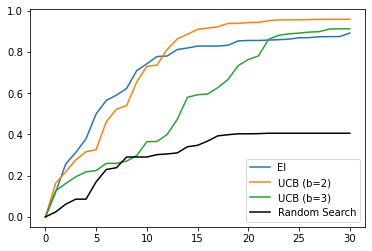

In [4]:
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ei)), label='EI')
# plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ucb_05)), label='UCB (b=0.5)')
# plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ucb_1)), label='UCB (b=1)')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ucb_2)), label='UCB (b=2)')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ucb_3)), label='UCB (b=3)')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_rand)), label='Random Search', c='k')
plt.legend()
plt.plot()